# 1: Replicate the baseline AI methodology using the open dataset 

## Install Requirements & Load Packages

In [1]:
# #conda env create -f environment.yml
# !conda env create -f environment.yml
# # !conda activate deforestation_2  # Then restart kernel

In [3]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import backend as K

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import rasterio
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
import sys

!pip install pyunpack patool rarfile segmentation-models rioxarray
from rarfile import RarFile
from keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  Using cached EasyProcess-1.1-py3-none-any.whl.metadata (855 bytes)
  Using cached entrypoint2-1.1-py2.py3-none-any.whl.metadata (1.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [patool]
  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 160.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 98.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [rioxarray]/8 [efficientnet]


In [31]:
# Document the used dependenies
# conda env export > environment.yml

## Download & Preprocess Datasets

In [ ]:
# Specify whether to download data or read in
download = False
base_dir = r"./Amazon Forest Dataset/"

### RGB

In [6]:
# Download data

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data/data.rar').extractall('', patool_path=patool_path)

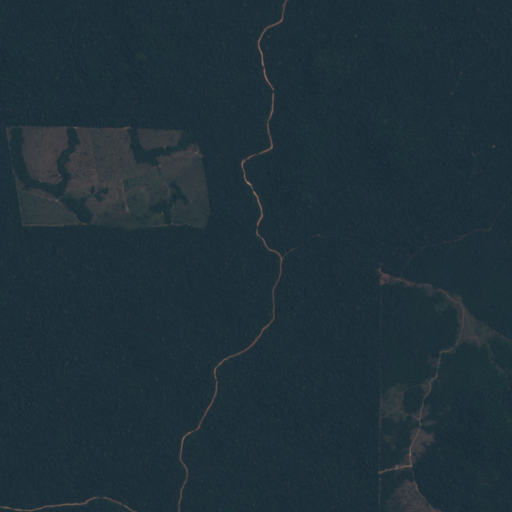

In [ ]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [ ]:
# %run preprocessing/preprocess-rgb-data.py

### 4-band Amazon

In [ ]:
download = False # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [ ]:
# Download data Amazon

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data2.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data2.rar').extractall('', patool_path=patool_path)

In [ ]:
# %run preprocessing/preprocess-4band-amazon-data.py

### 4-band Atlantic Forest

In [ ]:
download = False # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Download data (Atlantic Forest)

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data3.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data3.rar').extractall('', patool_path=patool_path)

In [ ]:
# %run preprocessing/preprocess-4band-atlantic-forest-data.py

VISUALIZING TRAINING DATA FROM ALL DATASETS

Processing: Amazon


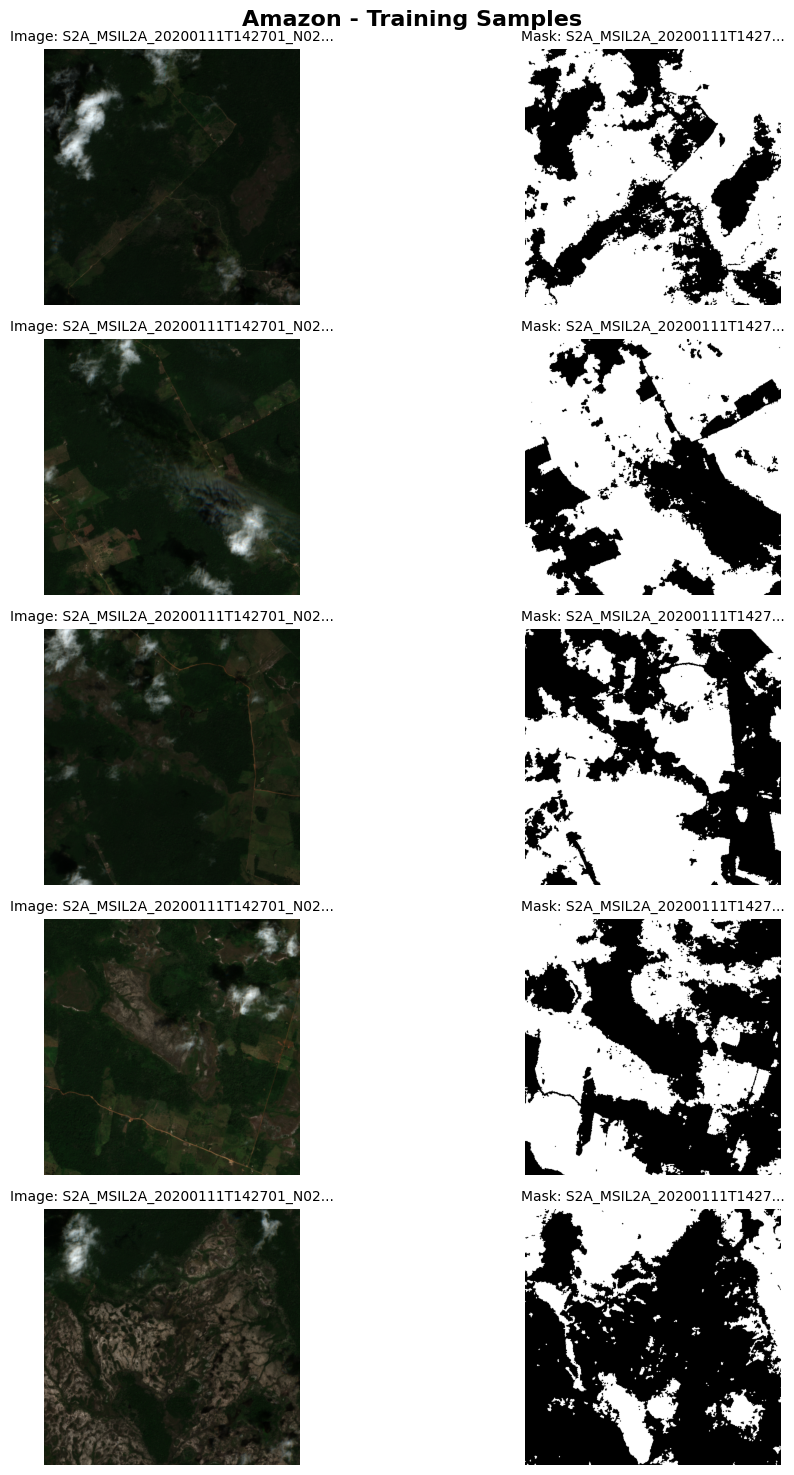

 Showed 5 samples from Amazon

Processing: Atlantic Forest


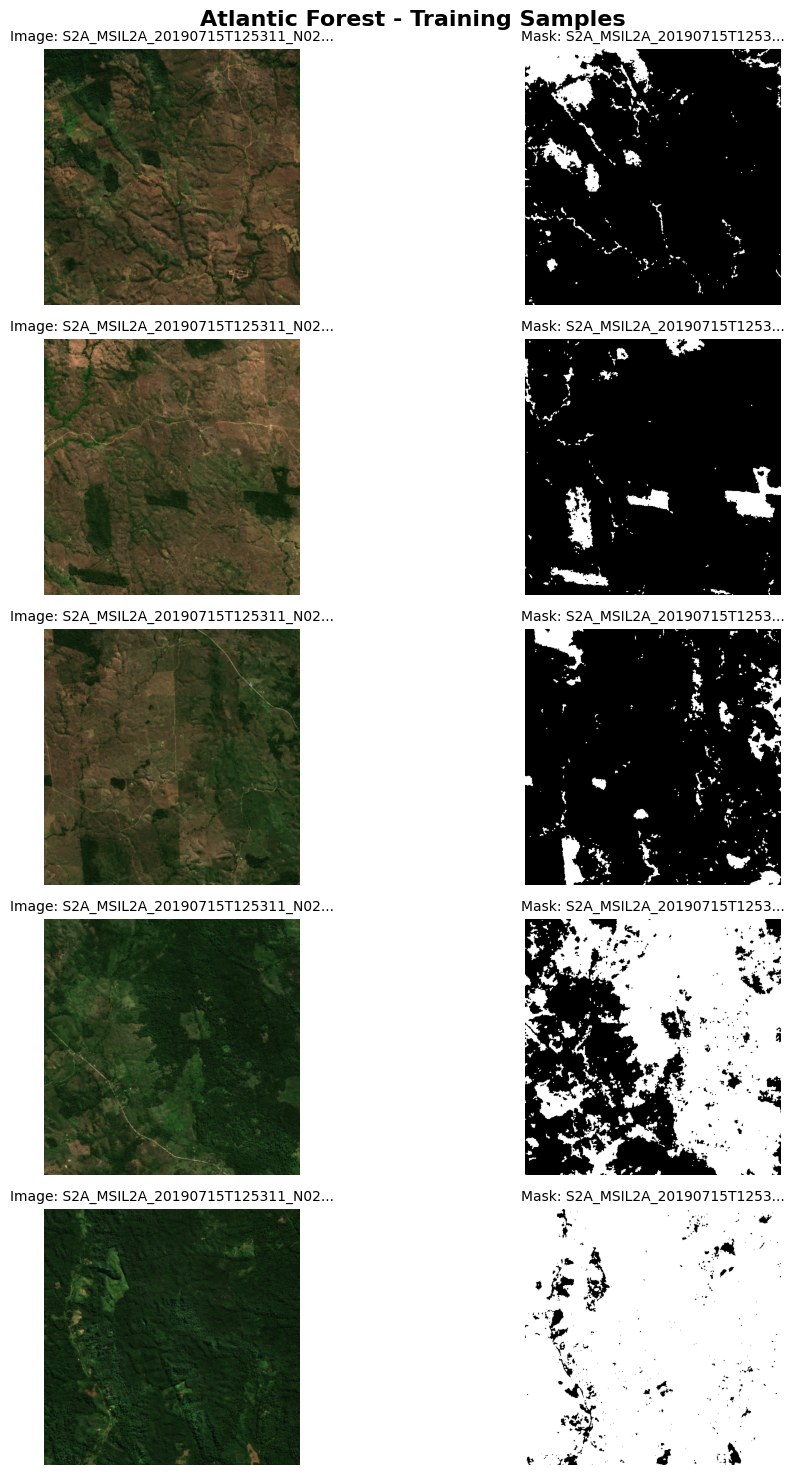

 Showed 5 samples from Atlantic Forest

Processing: Amazon Forest Dataset
Error loading Amazon_1110.tiff_25.tiff: name 'Image' is not defined
Error loading Amazon_1154.tiff_40.tiff: name 'Image' is not defined
Error loading Amazon_122.tiff_33.tiff: name 'Image' is not defined
Error loading Amazon_124.tiff_36.tiff: name 'Image' is not defined
Error loading Amazon_1279.tiff_29.tiff: name 'Image' is not defined


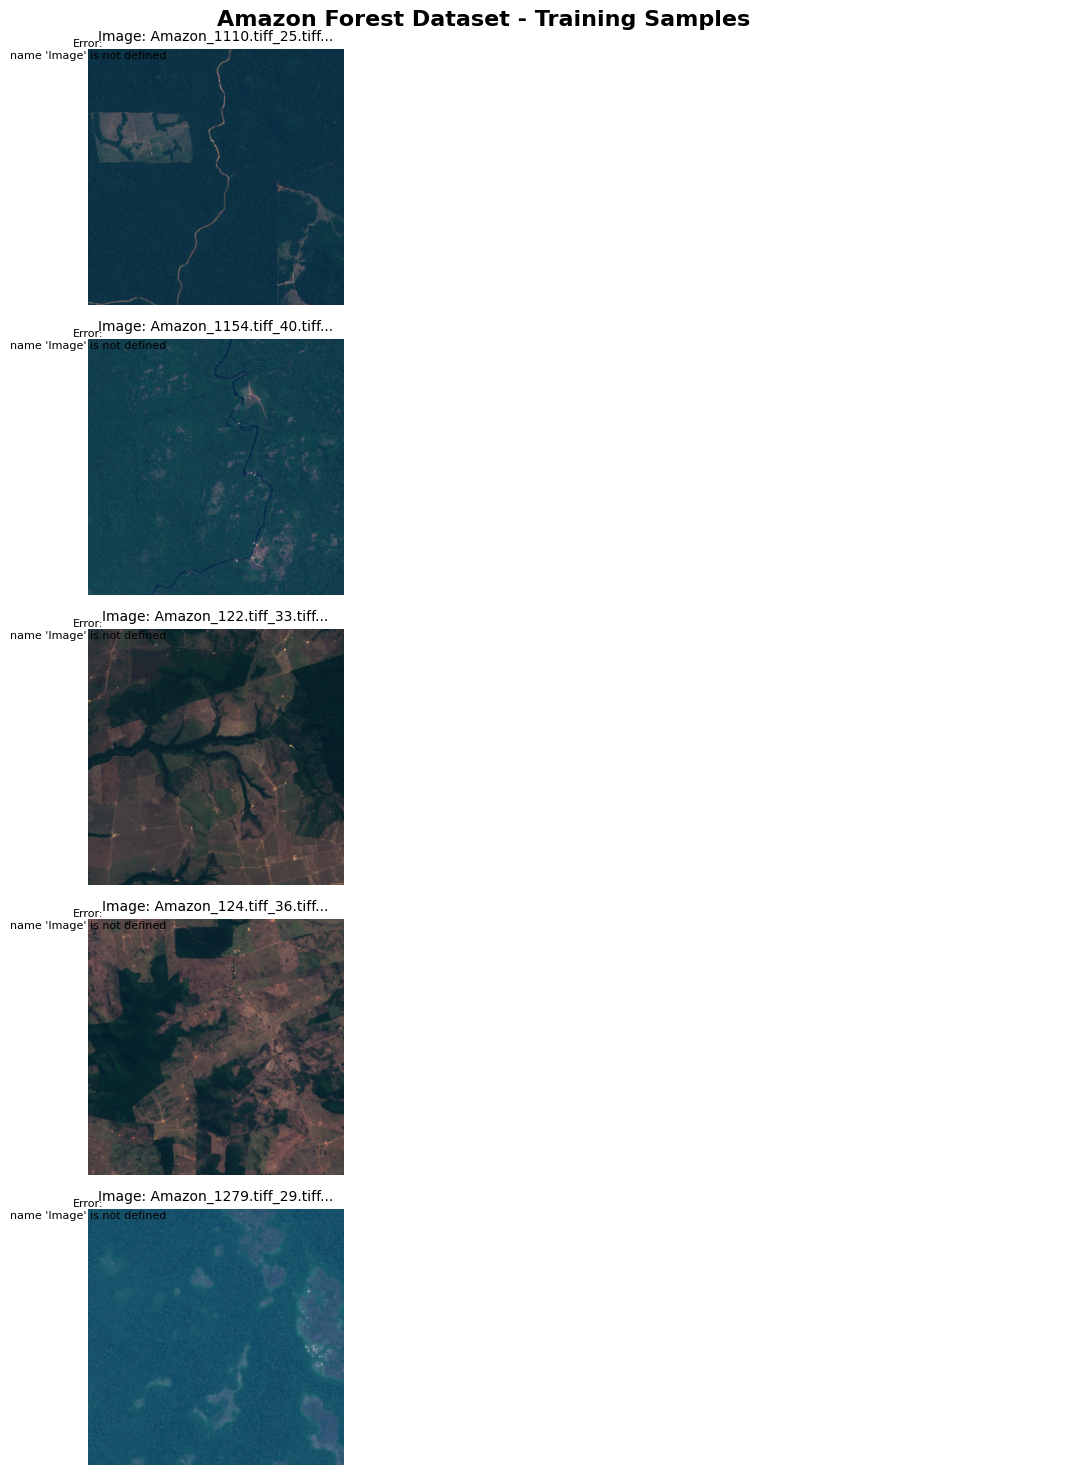

 Showed 5 samples from Amazon Forest Dataset

VISUALIZATION COMPLETE


In [7]:

# Define all datasets
datasets = {
    'Amazon': {
        'images': 'data/AMAZON/Training/image',
        'masks': 'data/AMAZON/Training/label',
        'img_ext': ['.tif'],
        'mask_ext': ['.tif']
    },
    'Atlantic Forest': {
        'images': 'data/ATLANTIC FOREST/Training/image',
        'masks': 'data/ATLANTIC FOREST/Training/label',
        'img_ext': ['.tif'],
        'mask_ext': ['.tif']
    },
    'Amazon Forest Dataset': {
        'images': 'data/Amazon Forest Dataset/Training/images',
        'masks': 'data/Amazon Forest Dataset/Training/masks',
        'img_ext': ['.tiff'],
        'mask_ext': ['.png']
    }
}

def show_dataset_samples(dataset_name, img_folder, mask_folder, img_ext, mask_ext, n=5):
    """Show n samples from a dataset"""
    
    # Get image files
    img_files = sorted([f for f in os.listdir(img_folder) 
                       if any(f.endswith(ext) for ext in img_ext)])[:n]
    
    if len(img_files) == 0:
        print(f"No image files found in {img_folder}")
        return
    
    # Create plot
    fig, axes = plt.subplots(n, 2, figsize=(12, n*3))
    fig.suptitle(f'{dataset_name} - Training Samples', fontsize=16, fontweight='bold')
    
    for i, img_file in enumerate(img_files):
        try:
            # Load image with rasterio (for .tif/.tiff)
            with rasterio.open(os.path.join(img_folder, img_file)) as src:
                img = src.read()
                
                # Handle multi-band images
                if img.shape[0] >= 3:
                    img = np.transpose(img[:3], (1, 2, 0))
                else:
                    img = img[0]
                
                # Normalize to 0-1
                img = (img - img.min()) / (img.max() - img.min())
            
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f'Image: {img_file[:30]}...', fontsize=10)
            axes[i, 0].axis('off')
            
            # Find corresponding mask
            base_name = os.path.splitext(img_file)[0]
            mask_found = False
            
            for ext in mask_ext:
                mask_path = os.path.join(mask_folder, base_name + ext)
                if os.path.exists(mask_path):
                    # Load mask - use PIL for PNG, rasterio for TIF
                    if ext == '.png':
                        mask = np.array(Image.open(mask_path))
                    else:
                        with rasterio.open(mask_path) as src:
                            mask = src.read(1)
                    
                    axes[i, 1].imshow(mask, cmap='gray')
                    axes[i, 1].set_title(f'Mask: {base_name + ext}'[:30] + '...', fontsize=10)
                    mask_found = True
                    break
            
            if not mask_found:
                axes[i, 1].text(0.5, 0.5, f'Mask not found\n(looked for: {base_name}.*)', 
                               ha='center', va='center', fontsize=8)
            axes[i, 1].axis('off')
            
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
            axes[i, 0].text(0.5, 0.5, f'Error:\n{str(e)[:50]}', ha='center', va='center', fontsize=8)
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f" Showed {len(img_files)} samples from {dataset_name}\n")

# Show samples for all datasets
print("=" * 60)
print("VISUALIZING TRAINING DATA FROM ALL DATASETS")
print("=" * 60 + "\n")

for name, config in datasets.items():
    if os.path.exists(config['images']):
        print(f"Processing: {name}")
        show_dataset_samples(name, 
                           config['images'], 
                           config['masks'],
                           config['img_ext'],
                           config['mask_ext'],
                           n=5)
    else:
        print(f" {name}: Path not found - {config['images']}\n")

print("=" * 60)
print("VISUALIZATION COMPLETE")
print("=" * 60)

## Adjustments to make training-ready and match way-of-working from paper

In [4]:
import glob
def load_npy_list(directory):
    files = sorted(glob.glob(os.path.join(directory, "*.npy")))
    arrays = [np.load(f) for f in files]
    return arrays, files

### RGB

In [5]:
BASE_DIR = r"data/amazon-processed-regular"

train_img_dir = os.path.join(BASE_DIR, "training", "images")
train_msk_dir = os.path.join(BASE_DIR, "training", "masks")
val_img_dir   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir   = os.path.join(BASE_DIR, "validation", "masks")

training_images, training_image_files   = load_npy_list(train_img_dir)
training_masks,  training_mask_files    = load_npy_list(train_msk_dir)
validation_images, validation_img_files = load_npy_list(val_img_dir)
validation_masks,  validation_msk_files = load_npy_list(val_msk_dir)

print(len(training_images), len(validation_images))
print("Example shape:", training_images[0].shape)

30 15
Example shape: (1, 512, 512, 3)


In [6]:
# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

print("Train size:", len(training_images))
print("Val size:", len(validation_images))

Train size: 25
Val size: 20


In [7]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

2025-12-05 18:11:29.927286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-05 18:11:37.605222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-05 18:11:37.608542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 4-band Amazon

In [8]:
BASE_DIR = r"data/amazon-processed-large" 

train_img_dir2 = os.path.join(BASE_DIR, "training", "images")
train_msk_dir2 = os.path.join(BASE_DIR, "training", "masks")
val_img_dir2   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir2   = os.path.join(BASE_DIR, "validation", "masks")

training_images2, training_image_files2   = load_npy_list(train_img_dir2)
training_masks2,  training_mask_files2    = load_npy_list(train_msk_dir2)
validation_images2, validation_img_files2 = load_npy_list(val_img_dir2)
validation_masks2,  validation_msk_files2 = load_npy_list(val_msk_dir2)

print(len(training_images2), len(validation_images2))
print("Example shape:", training_images2[0].shape)

250 100
Example shape: (1, 512, 512, 4)


In [9]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

In [99]:
BASE_DIR = r"data/amazon-processed-large" 

test_img_dir2 = os.path.join(BASE_DIR, "test", "images")
test_msk_dir2 = os.path.join(BASE_DIR, "test", "masks")

test_images2, test_image_files2   = load_npy_list(test_img_dir3)
test_masks2,  test_mask_files2    = load_npy_list(test_msk_dir3)

### 4-band atlantic

In [10]:
BASE_DIR = r"data/atlantic-processed-large" 

train_img_dir3 = os.path.join(BASE_DIR, "training", "images")
train_msk_dir3 = os.path.join(BASE_DIR, "training", "masks")
val_img_dir3   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir3   = os.path.join(BASE_DIR, "validation", "masks")

training_images3, training_image_files3   = load_npy_list(train_img_dir3)
training_masks3,  training_mask_files3    = load_npy_list(train_msk_dir3)
validation_images3, validation_img_files3 = load_npy_list(val_img_dir3)
validation_masks3,  validation_msk_files3 = load_npy_list(val_msk_dir3)

print(len(training_images3), len(validation_images3))
print("Example shape:", training_images3[0].shape)

250 100
Example shape: (1, 512, 512, 4)


In [11]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

In [98]:
BASE_DIR = r"data/atlantic-processed-large" 

test_img_dir3 = os.path.join(BASE_DIR, "test", "images")
test_msk_dir3 = os.path.join(BASE_DIR, "test", "masks")

test_images3, test_image_files3   = load_npy_list(test_img_dir3)
test_masks3,  test_mask_files3    = load_npy_list(test_msk_dir3)

## Functions

In [12]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [13]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

In [14]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

## Models

In [19]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     Input, Conv2D, Conv2DTranspose, MaxPooling2D,
#     Dropout, BatchNormalization, Activation, concatenate
# )
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import backend as K   # this one *has* int_shape

### U-Net

In [44]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [45]:
# Print model layers and number of parameters
UNet().summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_171 (Conv2D) │ (1, 512, 512, 64) │      1,792 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_162      │ (1, 512, 512, 64) │          0 │ conv2d_171[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_172 (Conv2D) │ (1, 512, 512, 64) │     36,928 │ activation_162[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_163      │ (1, 512, 512, 64) │          0 │ conv2d_172[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_61    │ (1, 256, 256, 64) │          0 │ activation_163[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_173 (Conv2D) │ (1, 256, 256,     │     73,856 │ max_pooling2d_61… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_164      │ (1, 256, 256,     │          0 │ conv2d_173[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_174 (Conv2D) │ (1, 256, 256,     │    147,584 │ activation_164[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_165      │ (1, 256, 256,     │          0 │ conv2d_174[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_62    │ (1, 128, 128,     │          0 │ activation_165[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_175 (Conv2D) │ (1, 128, 128,     │    295,168 │ max_pooling2d_62… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_166      │ (1, 128, 128,     │          0 │ conv2d_175[0][0]  │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (1, 128, 128,     │    590,080 │ activation_166[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_167      │ (1, 128, 128,     │          0 │ conv2d_176[0][0]  │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (1, 64, 64, 256)  │          0 │ activation_167[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (1, 64, 64, 512)  │  1,180,160 │ max_pooling2d_63… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_168      │ (1, 64, 64, 512)  │          0 │ conv2d_177[0][0]

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

### Attention U-Net

In [30]:
from keras import backend as K

In [64]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = x.shape
    shape_g = gating.shape

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = theta_x.shape

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = phi_g.shape

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = sigmoid_xg.shape

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(
        size=(2,2),
        interpolation='bilinear'
    )(sigmoid_xg)
    
    # upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    # # upsample_psi = Lambda(lambda t: tf.broadcast_to(t, shape=shape_x))(upsample_psi)

    # upsample_psi = Lambda(
    #         lambda t: tf.broadcast_to(t, shape=tf.shape(x)), 
    #         output_shape=shape_x[1:])(upsample_psi)

    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [65]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_438 (Conv2D) │ (1, 512, 512, 16) │        448 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_397      │ (1, 512, 512, 16) │          0 │ conv2d_438[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_439 (Conv2D) │ (1, 512, 512, 16) │      2,320 │ activation_397[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_398      │ (1, 512, 512, 16) │          0 │ conv2d_439[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_129   │ (1, 256, 256, 16) │          0 │ activation_398[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_440 (Conv2D) │ (1, 256, 256, 32) │      4,640 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_399      │ (1, 256, 256, 32) │          0 │ conv2d_440[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_441 (Conv2D) │ (1, 256, 256, 32) │      9,248 │ activation_399[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_400      │ (1, 256, 256, 32) │          0 │ conv2d_441[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_130   │ (1, 128, 128, 32) │          0 │ activation_400[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_442 (Conv2D) │ (1, 128, 128, 64) │     18,496 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_401      │ (1, 128, 128, 64) │          0 │ conv2d_442[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_443 (Conv2D) │ (1, 128, 128, 64) │     36,928 │ activation_401[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_402      │ (1, 128, 128, 64) │          0 │ conv2d_443[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_131   │ (1, 64, 64, 64)   │          0 │ activation_402[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_444 (Conv2D) │ (1, 64, 64, 128)  │     73,856 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_403      │ (1, 64, 64, 128)  │          0 │ conv2d_444[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_445 (Conv2D) │ (1, 64, 64, 128)  │    147,584 │ activation_403[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,006,292 (7.65 MB)

 Trainable params: 2,006,292 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

## Train Attention U-Net

### On RGB feature data

In [46]:
#
# Produce generators for training images
#

t_images = np.concatenate(training_images, axis=0)
t_masks = np.concatenate(training_masks, axis=0)

v_images = np.concatenate(validation_images, axis=0)
v_masks = np.concatenate(validation_masks, axis=0)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

In [47]:
t_images.shape

(25, 512, 512, 3)

In [72]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('models_self_trained/unet-attention-3d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
#save_model_am = ModelCheckpoint('models_self_trained/unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6497 - loss: 0.5809 - mse: 0.2000
Epoch 1: val_accuracy improved from None to 0.87907, saving model to models_self_trained/unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.7739 - loss: 0.5151 - mse: 0.1713 - val_accuracy: 0.8791 - val_loss: 0.4329 - val_mse: 0.1296
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8966 - loss: 0.3059 - mse: 0.0874
Epoch 2: val_accuracy improved from 0.87907 to 0.88179, saving model to models_self_trained/unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9077 - loss: 0.2673 - mse: 0.0744 - val_accuracy: 0.8818 - val_loss: 0.3063 - val_mse: 0.0916
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9139 - loss: 0.2246 - mse: 0.0642
Epoch 3: val_accuracy improved from 0.88179 to 0.90608, saving model to models_self_trained/unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accurac

In [73]:
# Save model history
np.save('models_self_trained/unet-attention-3d-history.npy',model_attention_unet.history.history)

### Train on 4-band Amazon data

In [76]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('models_self_trained/unet-attention-4d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8417 - loss: 0.3714 - mse: 0.1176
Epoch 1: val_accuracy improved from None to 0.75249, saving model to models_self_trained/unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8819 - loss: 0.2906 - mse: 0.0886 - val_accuracy: 0.7525 - val_loss: 0.4859 - val_mse: 0.1645
Epoch 2/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9104 - loss: 0.2306 - mse: 0.0674
Epoch 2: val_accuracy did not improve from 0.75249
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9269 - loss: 0.2066 - mse: 0.0580 - val_accuracy: 0.7486 - val_loss: 0.5488 - val_mse: 0.1771
Epoch 3/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9110 - loss: 0.2185 - mse: 0.0645
Epoch 3: val_accuracy did not improve from 0.75249
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9305 - loss: 0.1929 - mse: 0.0539 - val_accuracy: 0.7480 - val_loss: 0.5878 - val_mse: 0.1807
Epoch 4/60
249/250 ━━━━━━━━━━━━

In [77]:
# Save model history
np.save('models_self_trained/unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

### Train on 4-band Atlantic data

In [78]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('models_self_trained/unet-attention-4d-atlantic.keras', monitor='val_accuracy',verbose=1, save_best_only=True, )
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7635 - loss: 0.4673 - mse: 0.1582
Epoch 1: val_accuracy improved from None to 0.86083, saving model to models_self_trained/unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.8386 - loss: 0.3297 - mse: 0.1072 - val_accuracy: 0.8608 - val_loss: 0.4764 - val_mse: 0.1150
Epoch 2/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9233 - loss: 0.1871 - mse: 0.0568
Epoch 2: val_accuracy improved from 0.86083 to 0.87437, saving model to models_self_trained/unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9214 - loss: 0.1905 - mse: 0.0579 - val_accuracy: 0.8744 - val_loss: 0.4613 - val_mse: 0.1048
Epoch 3/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9318 - loss: 0.1663 - mse: 0.0504
Epoch 3: val_accuracy improved from 0.87437 to 0.87518, saving model to models_self_trained/unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━

In [79]:
# Save model history
np.save('models_self_trained/unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

## Import Models and Compute Metrics

### RGB

In [74]:
# Load 3-dim models and history stats
attention_unet = load_model('models_self_trained/unet-attention-3d.keras', safe_mode=False) 
attention_unet_history = np.load('models_self_trained/unet-attention-3d-history.npy', allow_pickle='TRUE').item()

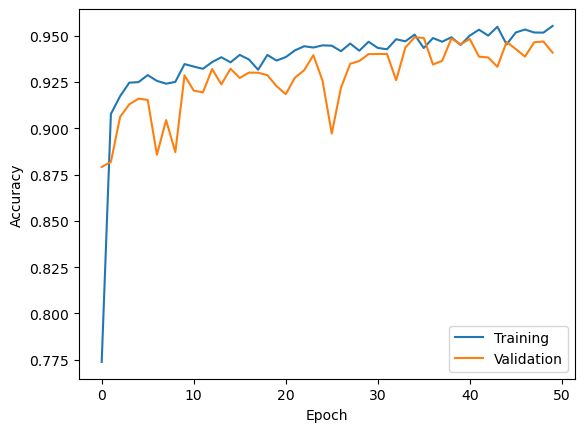

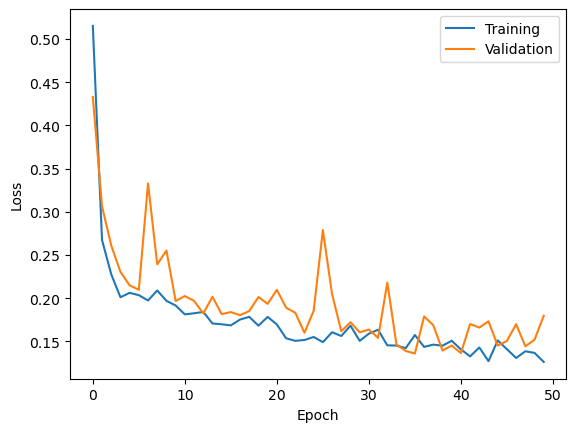

In [75]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [80]:
# Scores of each model
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [81]:
# Precision and recall of each model
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [82]:
# F1-scores of each model
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [83]:
# Print score eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

Attention U-Net accuracy:  0.949015998840332 0.046461544894929103


In [84]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

Attention U-Net precision:  0.956253480902447 0.03613858768247028


In [85]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

Attention U-Net recall:  0.949015998840332 0.046461544894929103


In [86]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

Attention U-Net F1-score:  0.9526209934835015


### 4-band Amazon Data

In [88]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('models_self_trained/unet-attention-4d.keras')
attention_unet_4d_history = np.load('models_self_trained/unet-attention-4d-history.npy', allow_pickle='TRUE').item()

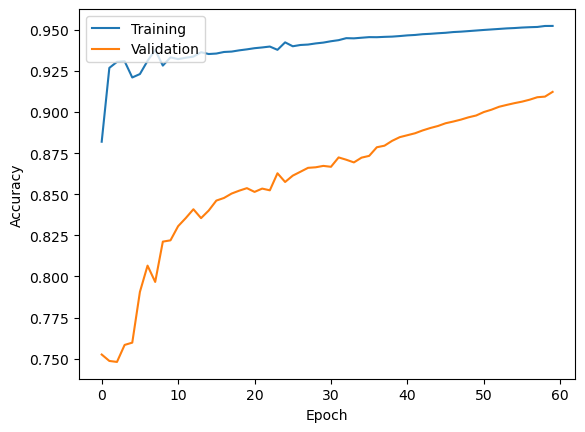

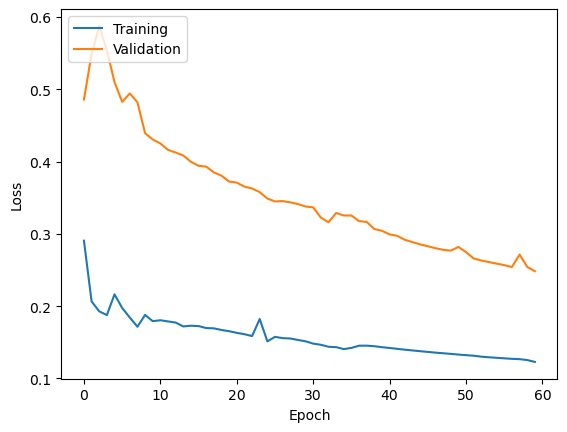

In [89]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [90]:
# Scores of each model
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [91]:
# Precision and recall of each model
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [92]:
# F1-scores of each model
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [93]:
# Print score eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

Attention U-Net accuracy:  0.9122661972045898 0.08022375944181125


In [94]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

Attention U-Net precision:  0.9358321064941445 0.04869059494580973


In [95]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

Attention U-Net recall:  0.9122661972045898 0.08022375944181125


In [96]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

Attention U-Net F1-score:  0.9238989022442643


### Amazon on unseen Atlantic data

In [100]:
# Score
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [101]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

Attention U-Net score:  0.8884221076965332 0.11258442092930478
Attention U-Net precision:  0.9219831243613379 0.06065092957945387
Attention U-Net recall:  0.8884221076965332 0.11258442092930478
Attention U-Net F1-score:  0.9048915415193091


### 4-band Atlantic Data

In [103]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('models_self_trained/unet-attention-4d-atlantic.keras')
attention_unet_4d_atlantic_history = np.load('models_self_trained/unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

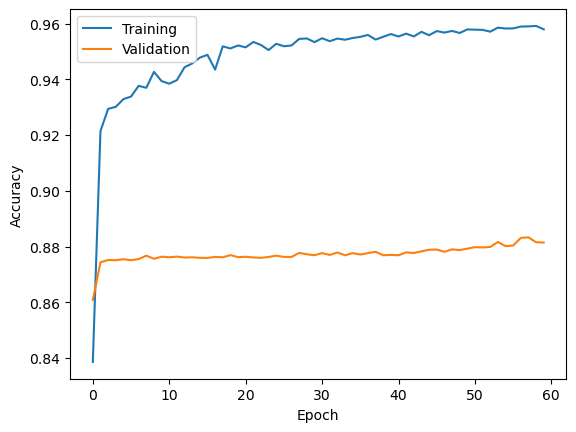

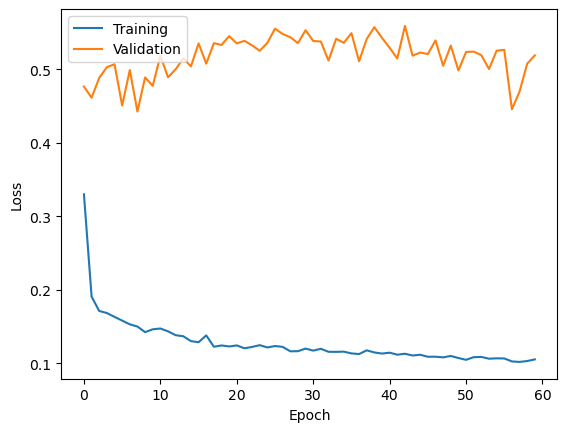

In [104]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [105]:
# Scores of each model
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [106]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

Attention U-Net score:  0.8833067703247071 0.11410080905426549
Attention U-Net precision:  0.9302633442958879 0.04726317016752735
Attention U-Net recall:  0.8833067703247071 0.11410080905426549
Attention U-Net F1-score:  0.9061771624675959


### Atlantic on unseen Amazon data

In [107]:
# Score
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [108]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

Attention U-Net score:  0.9167334238688151 0.06628149162511988
Attention U-Net precision:  0.9386529378644101 0.03954787611537986
Attention U-Net recall:  0.9167334238688151 0.06628149162511988
Attention U-Net F1-score:  0.9275637024184272


### Amazon and Atlantic unseen test data

In [109]:
# Amazon trained model on Amazon test data
# Scores of each model
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [110]:
# Atlantic trained model on Atlantic test data
# Scores of each model
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [111]:
# Print metrics for Amazon on Amazon Test set
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

Attention U-Net score:  0.8787220001220704 0.11506247698017134
Attention U-Net precision:  0.9180307658030005 0.043037955117760686
Attention U-Net recall:  0.8787220001220704 0.11506247698017134
Attention U-Net F1-score:  0.8979463908432349


In [112]:
# Print metrics for Atlantic on Atlantic Test set
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

Attention U-Net score:  0.8928888320922852 0.10986444181567702
Attention U-Net precision:  0.9324950491670985 0.03904708741865704
Attention U-Net recall:  0.8928888320922852 0.10986444181567702
Attention U-Net F1-score:  0.9122622632212622


## Produce metric datasets for export

### RGB data

In [114]:
scores_3d = [am_unet_score]
precision_3d = [am_unet_precision]
recall_3d = [am_unet_recall]
f1_scores_3d = [am_unet_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)

metrics_3d.to_csv('metrics_self_trained/metrics_3d_amazon.csv', index=False)

# Display results
print("\n=== Attention U-Net Metrics ===")
print(metrics_3d)


=== Attention U-Net Metrics ===
        classifier  accuracy  precision    recall  f1_score  accuracy_std  \
0  Attention U-Net  0.949016   0.956253  0.949016  0.952621      0.046462   

   precision_std  recall_std  
0       0.036139    0.046462  


### 4-band Amazon data

In [115]:
# 4D Amazon metrics
scores_4d = [am_unet_4d_score]
precision_4d = [am_unet_4d_precision]
recall_4d = [am_unet_4d_recall]
f1_scores_4d = [am_unet_4d_f1_score]

metrics_4d = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_self_trained/metrics_4d_amazon.csv', index=False)

### 4-band Atlantic Forest data

In [116]:
# 4D Atlantic Forest metrics
scores_4d_atl = [am_unet_4d_atlantic_score]
precision_4d_atl = [am_unet_4d_atlantic_precision]
recall_4d_atl = [am_unet_4d_atlantic_recall]
f1_scores_4d_atl = [am_unet_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_self_trained/metrics_4d_atlantic_forest.csv', index=False)

### Test set data

In [117]:
# 4D Amazon Test metrics
scores_4d_test = [am_unet_4d_score_test]
precision_4d_test = [am_unet_4d_precision_test]
recall_4d_test = [am_unet_4d_recall_test]
f1_scores_4d_test = [am_unet_4d_f1_score_test]

metrics_4d_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_self_trained/metrics_4d_amazon_test.csv', index=False)

In [118]:
# 4D Atlantic Forest Test metrics
scores_4d_atl_test = [am_unet_4d_atlantic_score_test]
precision_4d_atl_test = [am_unet_4d_atlantic_precision_test]
recall_4d_atl_test = [am_unet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [am_unet_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_self_trained/metrics_4d_atlantic_forest_test.csv', index=False)

### Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [119]:
# Amazon on Atlantic metrics
scores_amazon_on_atlantic = [am_unet_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [am_unet_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [am_unet_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [am_unet_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_self_trained/metrics_4d_amazon_on_atlantic.csv', index=False)

In [120]:
# Atlantic on Amazon metrics
scores_atlantic_on_amazon = [am_unet_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [am_unet_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [am_unet_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [am_unet_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_self_trained/metrics_4d_atlantic_on_amazon.csv', index=False)

# Comparison with baseline results in paper